# Your First Optimization Problem

Let's solve your first optimization problem in Pyomo.

## Cloud Computing with Google Colab

We will include the following code at the top of our notebooks to configure Google Colab.

In [1]:
## Tip: Please put code like this at the top of your notebook.
# We want all of the module/package installations to start up front

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

What does this code do? If we run it on Google Colab, the code first downloads `helper.py`. This small utility then helps us install Pyomo and the needed solvers (often via IDAES).

## Mathematical Model

Let's start with a purely mathematical example:

$$\begin{align*} \min_{x} \quad & x_1^2 + 2 x_2^2 - x_3 \\
\mathrm{s.t.} \quad & x_1 + x_2 = 1 \\
& x_1 + 2 x_2 - x_3 = 5 \\
& -10 \leq x_1, x_2, x_3 \leq 10 
\end{align*} $$

We want to solve the constrained optimization problem numerically.

## Define the Model in Pyomo

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Fill in the missing constraint.
</div>

In [2]:
import pyomo.environ as pyo

# Create instance of concrete Pyomo model.
# concrete means all of the sets and model data are specified at the time of model construction.
# In this class, you'll use a concrete model.
m = pyo.ConcreteModel()

## Declare variables with initial values with bounds
m.x1 = pyo.Var(initialize=1, bounds=(-10, 10))
m.x2 = pyo.Var(initialize=1, bounds=(-10, 10))
m.x3 = pyo.Var(initialize=1, bounds=(-10, 10))

## Declare objective
m.OBJ = pyo.Objective(expr=m.x1**2 + 2*m.x2**2 - m.x3, sense = pyo.minimize)

## Declare equality constraints
m.h1 = pyo.Constraint(expr= m.x1 + m.x2 == 1)

### BEGIN SOLUTION
m.h2 = pyo.Constraint(expr= m.x1 + 2*m.x2 - m.x3 == 5)
### END SOLUTION

## Display model
m.pprint()

3 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
    x3 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals

1 Objective Declarations
    OBJ : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : x1**2 + 2*x2**2 - x3

2 Constraint Declarations
    h1 : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :   1.0 : x1 + x2 :   1.0 :   True
    h2 : Size=1, Index=None, Active=True
        Key  : Lower : Body           : Upper : Active
        None :   5.0 : x1 + 2*x2 - x3 :   5.0 :   True

6 Declarations: x1 x2 x3 OBJ h1 h2


```{dropdown} Click to see the solution to the activity

```python
m.h2 = pyo.Constraint(expr= m.x1 + 2*m.x2 - m.x3 == 5)

## Solve using Ipopt

Toward the end of the semester we will learn, in perhaps more detail than you care, what makes Ipopt work under the hood. For now, we'll use it as a computational tool.

In [3]:
opt1 = pyo.SolverFactory('ipopt')
status1 = opt1.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## Inspect the Solution

Now let's inspect the solution. We'll use the function `value()` to extract the numeric value from the Pyomo variable object.

In [4]:
## Return the solution
print("x1 = ",pyo.value(m.x1))
print("x2 = ",pyo.value(m.x2))
print("x3 = ",pyo.value(m.x3))
print("\n")

x1 =  0.4999999999666826
x2 =  0.5000000000333175
x3 =  -3.499999999966682




## Visualize the Solution

Is our answer correct?

We can solve this optimization problem with guess and check. If we guess $x_3$, we can then solve the constraints for $x_1$ and $x_2$:

Constraints:

$$\begin{align*} & x_1 + x_2 = 1 \\
& x_1 + 2 x_2 - x_3 = 5 
\end{align*} $$

$$\begin{bmatrix}
1 & 1 \\
1 & 2
\end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} 1 \\ 5 + x_3 \end{bmatrix}$$

We can then evaluate the objective. Let's see the graphical solution to our optimization problem.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Activity</b>: Verify you agree with how to translate the two linear constraints into a linear system of questions.</div>

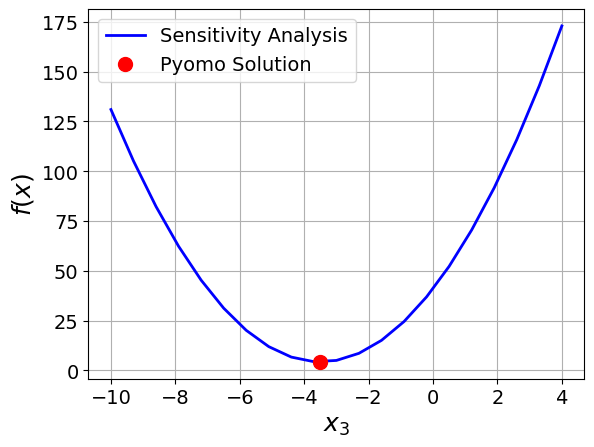

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def constraints(x3):
    ''' Solve the linear constraints
    
    Args:
        x3: Value for the decision variable x3
        
    Returns:
        x1 and x2: Values calculated from the constraints
    '''

    # Define the matrices in the above equations
    A = np.array([[1, 1],[1, 2]])
    b = np.array([1, 5+x3])

    # Solve the linear system of equations
    z = np.linalg.solve(A,b)
    x1 = z[0]
    x2 = z[1]
    return x1, x2

# Define a lambda function to plot the objective
objective = lambda x1, x2, x3: x1**2 + 2*x2**2 - x3

# Guess many values of x3.
x3_guesses = np.linspace(-10,4,21)
obj = []
for x3 in x3_guesses:
    # Solve the constraints to determine x1 and x2
    x1, x2 = constraints(x3)
    # Calculate the store the objective function value
    obj.append(objective(x1,x2,x3))

# Plot the objective function value versus x3
plt.plot(x3_guesses, obj,color='blue',linewidth=2,label="Sensitivity Analysis")
plt.xlabel("$x_3$",fontsize=18)
plt.ylabel("$f(x)$",fontsize=18)

# Plot the solution from Pyomo
x3_sln = pyo.value(m.x3)
obj_sln = pyo.value(m.OBJ)
plt.plot(x3_sln, obj_sln,marker='o',color='red',markersize=10,label="Pyomo Solution",linestyle='')
plt.legend()
plt.grid(True)
plt.show()